In [1]:
import numpy as np
import math
import itertools
import sys
import matplotlib.pyplot as plt
import copy

from scipy.interpolate import UnivariateSpline
from mpl_toolkits import mplot3d
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import distance_matrix
from scipy.spatial import distance

%load_ext autoreload
%autoreload 2
import cup_quasi_periodic_detection as cqpd

In [2]:
d = 4
tau = (3/4)*np.sqrt(3)*np.pi

In [3]:
t = np.linspace(0,30*np.pi, 1000)
f = np.cos(t) + np.cos(np.sqrt(3)*t)

In [4]:
def sw_map(f, t, w, d, num_points):
    '''
    This function computes the sliding window embeding of a given signal f.
    
    :param f: signal represented as a 1D array.
    :param t: time variable represented as a 1D array.
    :param w: window size
    :param d: d + 1 will be the dimension of the embedding
    :param num_points: number of points in the final sliding window point cloud 
    '''
    
    tau = w/d
    
    
    # Step 1 :
    
    T =  np.linspace(t[0], t[-1]-w,num_points)
    
    tt = np.dot(np.ones((d+1,1)), T.reshape(1,-1)) + tau*np.dot(np.arange(d+1).reshape(-1,1), np.ones((1,num_points))) 
    
    
    # Step 2 :
    
    interpolation = UnivariateSpline(t, f, s=0)
    
    point_cloud = np.apply_along_axis(interpolation, 1, tt)
    
    return point_cloud.transpose()

In [5]:
pc = sw_map(f,t, d*tau, d, 300)

dm_X = distance.cdist(pc, pc)


# Maxmin subsampling

ind_L, cover_r = cqpd.maxmin(dm_X, 300)

dm_L = dm_X[ind_L,:][:,ind_L]

In [6]:
q = 2

result = ripser(dm_L, coeff=q, distance_matrix=True, maxdim=2, do_cocycles=True)

In [10]:
diagrams = result['dgms']
cocycles = result['cocycles']

# H_1 processing and sorting

H_1 = cocycles[1]
H_1_diagram = diagrams[1]
H_1_persistence = H_1_diagram[:,1] - H_1_diagram[:,0]
H_1_persistence_sort_ind = H_1_persistence.argsort()

# Cup product 

cocycle_1_ind = -1
cocycle_2_ind = -2

cocycle_1 = H_1[H_1_persistence_sort_ind[cocycle_1_ind]]
cocycle_2 = H_1[H_1_persistence_sort_ind[cocycle_2_ind]]

cup = cqpd.cup_product_cochains(cocycle_1, cocycle_2, q)

# Rips complex

rips_com, orders, diameters = cqpd.rips_complex(dm_L, 0.5)

# Coboundary matrices

d0 = cqpd.delta_0(rips_com['0'], rips_com['1'])
d1 = cqpd.delta_1(rips_com['1'], rips_com['2'])

# delta^1 reducition

R1, V1, low = cqpd.matrix_reduction(d1)

# Cup product as a cochain 

cochain = np.zeros(rips_com['2'].shape[0])

cup = np.array(cup)

for i in range(len(cup)):
    simplex = cup[i,2::-1]
    
    j = np.where((rips_com['2'] == simplex).all(axis=1))
    
    cochain[j] = cup[i,3]
    
cochain = cochain[::-1]

# Backwards substitution

y, index = cqpd.backwards_substitution(R1, low, cochain)

# Cohomological death
if index != -1:
    ind_goal = rips_com['2'][len(rips_com['2'])-index-1]
else:
    ind_goal = rips_com['2'][-1]

death = np.max(dm_L[np.ix_(ind_goal[::-1],ind_goal[::-1])])

# Cohomological birth: as minimum of birth between classes

birth = min(H_1_diagram[H_1_persistence_sort_ind[cocycle_1_ind]][1], H_1_diagram[H_1_persistence_sort_ind[cocycle_2_ind]][1])

# Plot of persistent diagram + cup product

plt.scatter(diagrams[0][:,0], diagrams[0][:,1], label='H_0')
plt.scatter(diagrams[1][:,0], diagrams[1][:,1], label='H_1')
plt.scatter(diagrams[2][:,0], diagrams[2][:,1], label='H_2')

plt.scatter([death], [birth], label ='Cup')

chosen = diagrams[1][[H_1_persistence_sort_ind[cocycle_1_ind], H_1_persistence_sort_ind[cocycle_2_ind]],:]

plt.scatter(chosen[:,0], chosen[:,1], label='Selected classes', facecolors='none', edgecolors='r')

plt.legend(loc = 'lower right')

pad = .03

x_min = np.min([np.min(diagrams[0][:,0]), np.min(diagrams[1][:,0]), np.min(diagrams[2][:,0])])
x_max = np.max([np.max(diagrams[0][:,0]), np.max(diagrams[1][:,0]), np.max(diagrams[2][:,0])])

y_min = np.min([np.min(diagrams[0][:,1]), np.min(diagrams[1][:,1]), np.min(diagrams[2][:,1])])
y_max = np.max([np.nanmax(diagrams[0][:,1][diagrams[0][:,1] != np.inf]), 
                np.nanmax(diagrams[1][:,1][diagrams[1][:,1] != np.inf]), 
                np.nanmax(diagrams[2][:,1][diagrams[2][:,1] != np.inf])])

plt.plot(np.linspace(x_min - pad, x_max + 2*pad), np.linspace(x_min - pad, x_max + 2*pad), '--', c='black')
plt.hlines(y_max + pad, x_min - pad, x_max + 2*pad, linestyles='--')

plt.xlim(x_min - pad, x_max + 2*pad)
plt.ylim(0 - pad, y_max + 2*pad)

UnboundLocalError: local variable 'i' referenced before assignment

In [8]:
sort_ind = np.argsort(persistence)

In [9]:
def s2 (phi, theta):
    x = np.cos(phi)*np.sin(theta)
    y = np.sin(phi)*np.sin(theta)
    z = np.cos(theta)
    
    return np.array([x,y,z])

In [10]:
points_0 = s2(phi_0, theta_0)

points_s2 = np.array([s2(l[0], l[1]) for l in angles])

NameError: name 'phi_0' is not defined

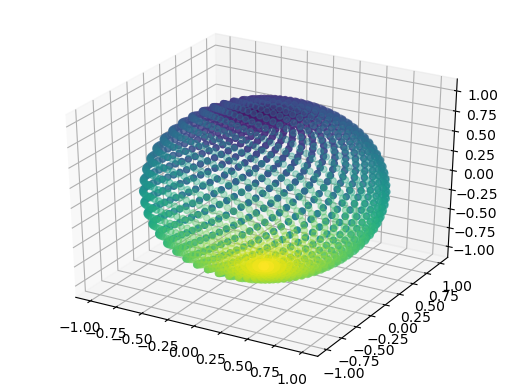

In [12]:
# Creating figure
fig = plt.figure()
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(points_s2[:,0], points_s2[:,1], points_s2[:,2], c = t)

In [13]:
ts_1 = np.arccos(np.dot(points_s2, points_0))

ts_1 = (1/(np.max(ts_1) - np.min(ts_1)))*ts_1

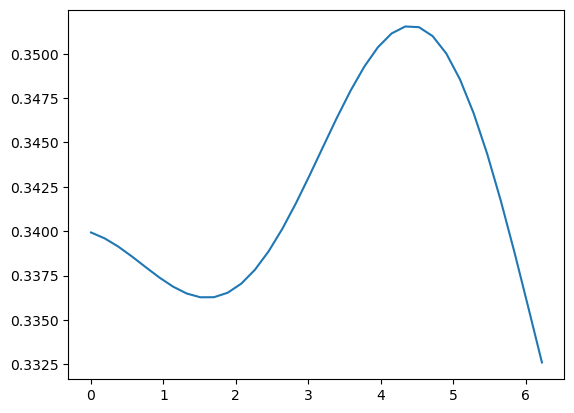

In [14]:
plt.plot(t[t <= 2*np.pi],ts_1[t <= 2*np.pi])

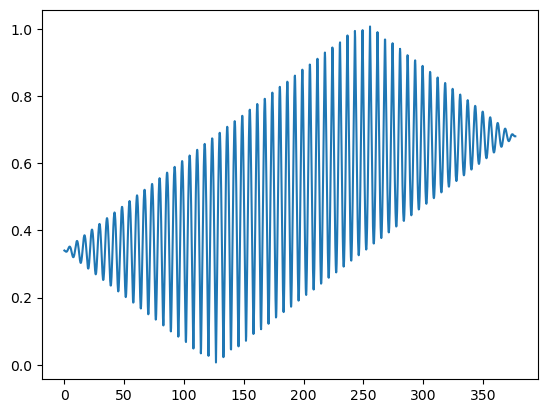

In [15]:
plt.plot(t,ts_1)

/home/lucho8908/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


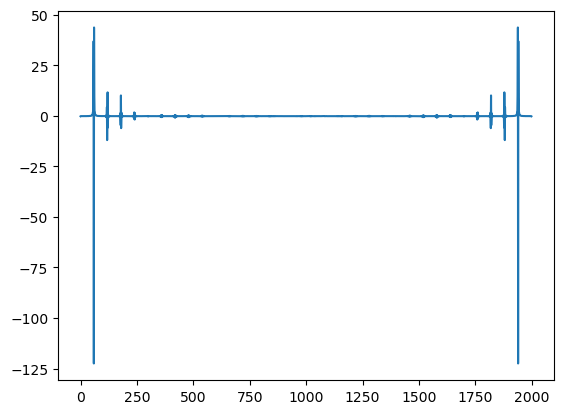

/home/lucho8908/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


11.315391248547527


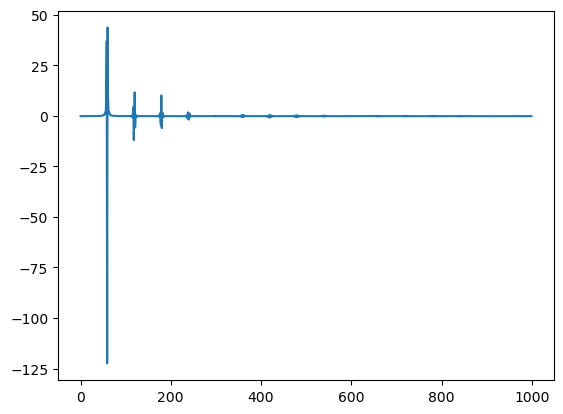

In [16]:
fourier = np.fft.fft(ts_1)
plt.plot(fourier[1:])
plt.show()

fourier_co_cnt = fourier[1:]

plt.plot(fourier_co_cnt[0: int(len(fourier)/2)])

ind_max = np.argmax(fourier_co_cnt[0: int(len(fourier)/2)])

print(t[ind_max])

In [17]:
d = 4
w = 2*np.pi*d/(d+1)

pc = sw_map(ts_1, t, w, d, 10000)

In [18]:
res = ripser(pc, maxdim=2, n_perm=300)

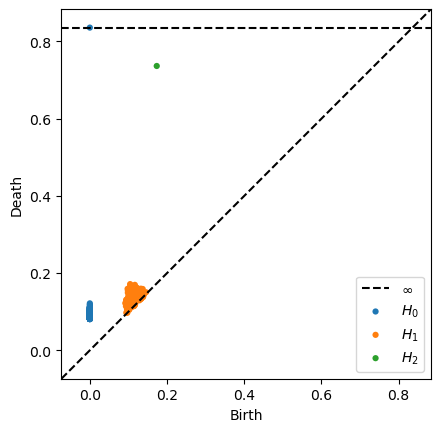

In [19]:
plot_diagrams(res['dgms'])

In [20]:
angles_2 = np.column_stack((t, (1/2)*t))

In [21]:
points_s2_2 = np.array([s2(l[0], l[1]) for l in angles_2])

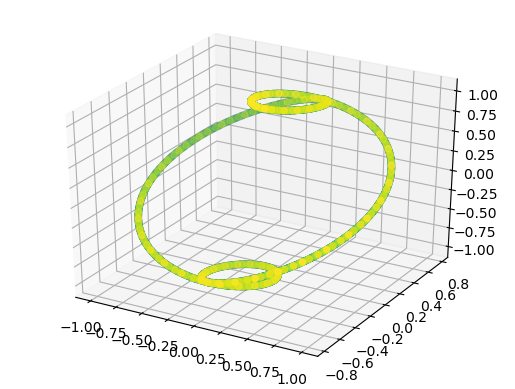

In [22]:
# Creating figure
fig = plt.figure()
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(points_s2_2[:,0], points_s2_2[:,1], points_s2_2[:,2], c = t)

In [23]:
# ts_2 = (1/3)*np.arccos(np.dot(points_s2_2, points_0))

ts_2 = (1/3)*(np.cos(t) + (1/3)*np.cos(3*t) + (1/5)*np.cos(5*t))

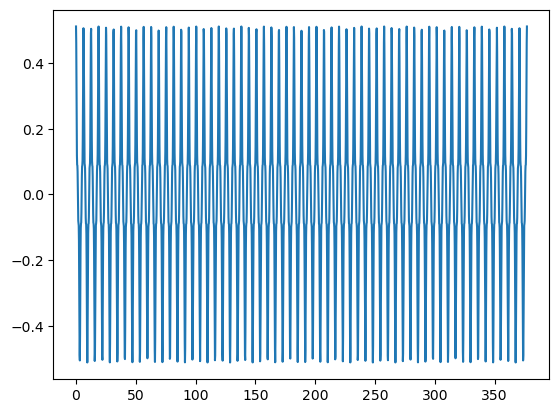

In [24]:
plt.plot(t, ts_2)

In [25]:
d = 3
w = 2*np.pi*d/(d+1)

pc = sw_map(ts_2, t, w, d, 300)

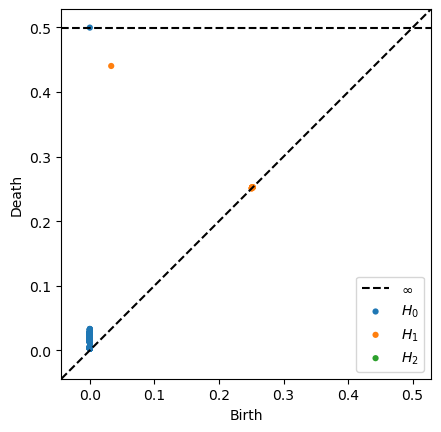

In [26]:
res = ripser(pc, maxdim=2)
plot_diagrams(res['dgms'])

In [27]:
# angles_3 = np.column_stack((t, 2*(1/2)*t))
angles_3 = np.column_stack((t, np.pi/2*np.ones(len(t))))

In [28]:
points_s2_3 = np.array([s2(l[0], l[1]) for l in angles_3])

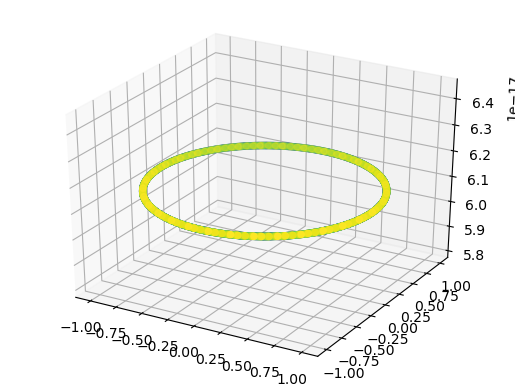

In [29]:
# Creating figure
fig = plt.figure()
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(points_s2_3[:,0], points_s2_3[:,1], points_s2_3[:,2], c = t)

In [30]:
# ts_3 = (1/2)*np.arccos(np.dot(points_s2_3, points_0))

ts_3 = (1/2)*(np.sin(t) + 0* np.sin(3*t) - (1/5)*np.sin(5*t))

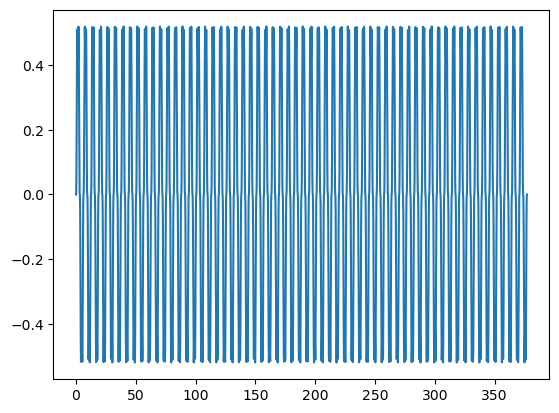

In [31]:
plt.plot(t,ts_3)

In [32]:
d = 4
w = 2*np.pi*d/(d+1)

pc = sw_map(ts_3, t, w, d, 300)

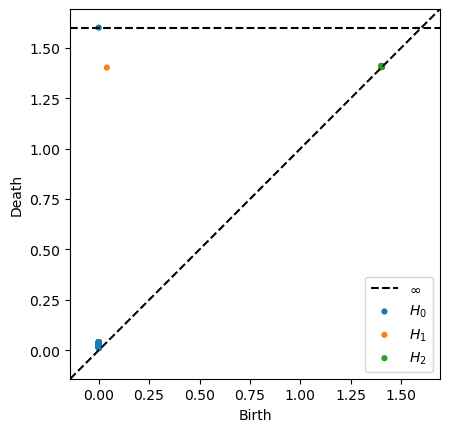

In [33]:
res = ripser(pc, maxdim=2)
plot_diagrams(res['dgms'])

In [34]:
ts = np.concatenate((ts_2 - ts_2[-1] + ts_1[0] , ts_1, ts_3 - ts_3[0] + ts_1[-1]))

t_1 = t
t_2 = t + np.max(t) + t[1]
t_3 = t + np.max(t_2) + t[1]

t_long = np.concatenate((t_1, t_2, t_3))

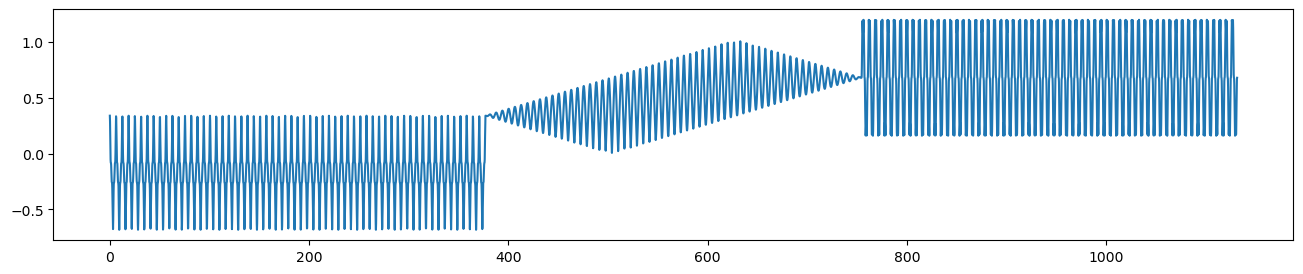

In [56]:
plt.figure(figsize=(16,3))
plt.plot(t_long, ts)

In [36]:
d = 6
w = 2*np.pi*d/(d+1)

pc = sw_map(ts, t_long, w, d, 10000)

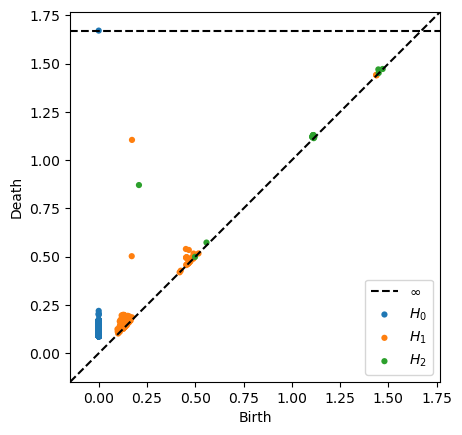

In [55]:
res = ripser(pc, maxdim=2, n_perm=500)
plot_diagrams(res['dgms'])